In [1]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
import numpy as np
import plotly.express as px
import shap
import seaborn as sns
from IPython import display
import matplotlib.pyplot as plt
import awswrangler as wr
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    multilabel_confusion_matrix,
)
from catboost.utils import select_threshold
from skmultilearn.model_selection.iterative_stratification import (
    IterativeStratification,
)
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm import tqdm
from catboost.utils import get_roc_curve, select_threshold
from torchmetrics.classification import BinaryPrecisionRecallCurve
from supervised.automl import AutoML
import warnings
from loguru import logger
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost.utils import eval_metric
from catboost import metrics as cat_metrics
from sklearn.utils import class_weight

warnings.filterwarnings("ignore")


/home/alextay96/anaconda3/envs/work/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to load image Python extension: /home/alextay96/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE


In [2]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
    path=f"s3://multilabel_df/",
    dataset=True,
)
multilabelDf.columns

Index(['vision_bonnet', 'vision_bumper_front', 'vision_grille',
       'vision_headlamp_rh', 'vision_headlamp_lh', 'vision_door_front_lh',
       'vision_door_front_rh', 'vision_engine', 'vision_bumper_rear',
       'vision_misc', 'vision_front_panel', 'vision_non_external',
       'vision_wheel', 'vision_fender_front_lh', 'vision_fender_front_rh',
       'vision_rear_quarter_lh', 'vision_tail_lamp_lh', 'vision_tail_lamp_rh',
       'vision_windscreen_front', 'vision_rear_compartment',
       'vision_rear_panel', 'vision_rear_quarter_rh', 'vision_door_rear_rh',
       'vision_door_rear_lh', 'bonnet', 'bumper_front', 'grille',
       'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh',
       'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator',
       'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel',
       'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh',
       'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh',
       'fog_lamp_l

In [3]:
# multilabelDf.replace(pd.NA, 0, inplace=True)

In [4]:
multilabelDf["Assembly_Type"]

0         3
1         3
2         3
3         3
4         3
         ..
598121    3
598122    3
598123    3
598124    2
598125    3
Name: Assembly_Type, Length: 598126, dtype: Int64

In [5]:
multilabelDf[multilabelDf["Model"] == "NA"]

,vision_bonnet,vision_bumper_front,vision_grille,vision_headlamp_rh,vision_headlamp_lh,vision_door_front_lh,vision_door_front_rh,vision_engine,vision_bumper_rear,vision_misc,...,Assembly_Type,Vehicle_Still_Driveable,NCB_Stat,Claim_Type,Vehicle_Type,Sum_Insured,Repairer,Repairer_Apprv_Count,Collision_With,Handling_Insurer


In [6]:
wr.config.s3_endpoint_url = "http://192.168.1.4:8333"

multilabelDf = wr.s3.read_parquet(
        path=f"s3://multilabel_df/",
        dataset=True,
    )
allVisionFeatures = [x for x in multilabelDf.columns if "vision_" in x]
caseFeatures = [
    "Circumstances_of_Accident",
    "Model",
    # "Vehicle_Still_Driveable",
    # "NCB_Stat",
    # "Assembly_Type",
    # "Claim_Type",
    "Vehicle_Type",
    # # "Sum_Insured",
    # "Repairer",
    # # # "Repairer_Apprv_Count",
    # "Collision_With",
    # "Handling_Insurer",
]
exclude = ['Sum_Insured', 'Repairer', 'Repairer_Apprv_Count', 
"Vehicle_Still_Driveable",
    "NCB_Stat",
    "Assembly_Type",
    "Claim_Type",
    # "Vehicle_Type",
    "Sum_Insured",
    "Repairer",
    "Repairer_Apprv_Count",
    "Collision_With",
    "Handling_Insurer"
     ]
# contFeatures = ["Sum_Insured", "Repairer_Apprv_Count"]
allInputFeature = caseFeatures + allVisionFeatures
allTargetCol = [
   'bonnet', 'bumper_front', 'grille', 'fog_lamp_rh', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'air_conditioning', 'cooling_fan', 'radiator', 'bumper_rear', 'misc', 'engine', 'airbag', 'front_panel', 'undercarriage', 'wheel', 'fender_front_lh', 'fender_front_rh', 'door_mirror_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'fog_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_mirror_lh', 'door_rear_lh', 'windscreen_rear'
]
saloonPredDf = pd.read_csv(
    "/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/saloon_focal_480_aug_2/Saloon - 4 Dr_imgs_pred_output.csv"
)
hatchBackDf = pd.read_csv("/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/hatchback_focal_480_aug/Hatchback - 5 Dr_imgs_pred_output.csv")
suvDf = pd.read_csv("/home/alextay96/Desktop/all_workspace/new_workspace/DLDataPipeline/data/results/suv_focal_480_aug/SUV - 5 Dr_imgs_pred_output.csv")

imgPredOutput = pd.concat([saloonPredDf, hatchBackDf, suvDf])
# imgPredOutput = saloonPredDf
allPredModel = []
allPreds = []
allGt = []
realTestDataDf = multilabelDf[caseFeatures + allTargetCol + ["CaseID"]].merge(
    imgPredOutput, on="CaseID"
)
realTestDataDf = realTestDataDf.loc[
    :, ~realTestDataDf.columns.str.contains("^Unnamed")
]
trainDf = multilabelDf[
    ~multilabelDf["CaseID"].isin(realTestDataDf["CaseID"].unique().tolist())
]
# trainDf = trainDf.sample(frac=0.5)
assert set(realTestDataDf["CaseID"].tolist()).isdisjoint(trainDf["CaseID"].tolist())
targetPart = [
    "fog_lamp_rh",
    "airbag",
    "undercarriage",
    "door_mirror_rh",
    "interior",
    "fog_lamp_lh",
    "door_mirror_lh",
    "windscreen_rear",
    "air_conditioning",
    "cooling_fan",
    "radiator"
]
# targetPart = [
#      'bonnet', 'bumper_front', 'grille', 'headlamp_lh', 'headlamp_rh', 'door_front_lh', 'door_front_rh', 'bumper_rear', 'misc', 'engine', 'front_panel', 'wheel', 'fender_front_lh', 'fender_front_rh', 'rear_quarter_lh', 'interior', 'tail_lamp_lh', 'tail_lamp_rh', 'windscreen_front', 'rear_compartment', 'rear_panel', 'rear_quarter_rh', 'door_rear_rh', 'door_rear_lh'
# ]
# targetCol = list(set(targetPart) & set(allTargetCol))
targetCol = allTargetCol


In [7]:
partFPThreshold = {
    # "bumper_front" : 0.3,
    # "headlamp_lh" : 0.3,
    # "headlamp_rh" : 0.3,
    # "bumper_rear":0.3,
    # "misc":0.3,
    # "engine":0.3,
     "cooling_fan" : 0.3,
    "radiator" : 0.3,
    "air_conditioning" : 0.3

}
partFNThreshold = {
    "windscreen_front" : 0.4,
    "windscreen_rear" : 0.4,
    "door_rear_lh" : 0.4,
    "door_rear_rh" : 0.4,
    "door_mirror_lh" : 0.4,
    "door_mirror_rh" : 0.4,
    "door_mirror_rh" : 0.4,
    "rear_quarter_lh" : 0.4,
    "rear_quarter_rh" : 0.4,


}
noClassWeightPart=  [
    "cooling_fan",
    "radiator",
    "air_conditioning"
]

In [8]:

for part in tqdm(targetCol):
    logger.success(f"Start training for part : {part}")
    allCaseIdByPart = []
    allPredByPart = []
    allGtByPart = []
    trainCaseId = trainDf["CaseID"].tolist()
    tempTestDataDf = realTestDataDf
    # tempTestDataDf = realTestDataDf.groupby(part).head(5000)
    testCaseId = tempTestDataDf["CaseID"].tolist()
    # sampledDf = trainDf[allInputFeature + [part]].groupby(part).sample(frac=0.3)
    X_train = trainDf[allInputFeature]
    Y_train = trainDf[part].to_frame()
   
    X_test = tempTestDataDf[allInputFeature]
    Y_test = tempTestDataDf[part].to_frame()

    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    neg_count = len(Y_test[Y_test[part] == 0]) / len(Y_test)
    pos_weight = neg_count / pos_count
    train_pool = Pool(
        X_train, Y_train, cat_features=caseFeatures + allVisionFeatures
    )
    test_pool = Pool(X_test, Y_test, cat_features=caseFeatures + allVisionFeatures)
    clsWeight=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_train.values),y=Y_train.values.squeeze(1))
    logger.success(f"train_class_weight : {clsWeight}")

    testClsWeights = {
        0 : clsWeight[0],
        1 : clsWeight[1]

    }
    print(testClsWeights)
    sampleWeights = class_weight.compute_sample_weight(class_weight=testClsWeights, y=Y_test.values)
    print(f"Shape :{sampleWeights.shape}")
    # prCurve = MulticlassPrecisionRecallCurve(num_classes=2, thresholds=11)
    clf = CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="F1",
            # iterations=200,
            early_stopping_rounds=300,
            task_type="GPU",
            class_weights= clsWeight,
            # auto_class_weights="SqrtBalanced",
            use_best_model=True,
            # scale_pos_weight=20
            # class_names=["not_dmg", "dmg"],
        )
    clf.fit(train_pool, eval_set=test_pool, metric_period=100, plot=False, verbose=1)
    test_predict = clf.predict(test_pool)
    # if (part in partFPThreshold):
    #     logger.success(f"Trade off false positive : {part}")
    #     (fpr, tpr, thresholds) = get_roc_curve(clf, test_pool, plot=False)
    #     boundary = select_threshold(clf, curve=(fpr, tpr, thresholds), FPR=partFPThreshold[part])
    #     clf.set_probability_threshold(boundary)
    #     test_predict = clf.predict(X_test)
    # elif part in partFNThreshold:
    #     logger.success(f"Trade off false negative : {part}")
    #     (fpr, tpr, thresholds) = get_roc_curve(clf, test_pool, plot=False)
    #     boundary = select_threshold(clf, curve=(fpr, tpr, thresholds), FNR=partFNThreshold[part])
    #     clf.set_probability_threshold(boundary)
    #     test_predict = clf.predict(X_test)
    acc = accuracy_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    confMat = confusion_matrix(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    pos_count = len(Y_test[Y_test[part] == 1]) / len(Y_test)
    pos_count_abs = len(Y_test[Y_test[part] == 1])
    # catboostF1 = cat_metrics.F1(Y_test.values.astype(np.int64), test_predict)
    tn = confMat[0][0]
    tp = confMat[1][1]
    fp = confMat[0][1]
    fn = confMat[1][0]
    totalSample = fp + fn + tp + tn
    acc = (tp + tn) / (fp + fn + tp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  (2 * precision * recall) / (precision + recall)
    f1_weighted = f1_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    # precision_weighted = precision_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)
    # recall_weighted = recall_score(Y_test.values.astype(np.int64), test_predict, sample_weight=sampleWeights)

    logger.success(f"F1 for part : {part} = {f1}")
    logger.success(f"Weighted F1 scikit for part : {part} = {f1_weighted}")

    # assert (tp / (tp + fn)) + (fn / (tp + fn)) == (tn / (tn + fp)) + (
    #     fp / (tn + fp)
    # )

    allPredModel.append(
        {
            "part": part,
            "tp": tp / (tp + fn),
            "tn": tn / (tn + fp),
            "fp": fp / (tn + fp),
            "fn": fn / (tp + fn),
            "acc": acc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "pos_count": pos_count,
            "pos_count_abs": pos_count_abs,

        }
    )
    assert len(testCaseId) == len(test_predict)
    assert len(testCaseId) == len(Y_test)

    allPreds.append({"CaseID": testCaseId, part: test_predict})
    allGt.append({"CaseID": testCaseId, part: Y_test.values.squeeze(1)})


  0%|          | 0/34 [00:00<?, ?it/s]2022-12-27 09:52:51.602 | SUCCESS  | __main__:<module>:2 - Start training for part : bonnet
2022-12-27 09:52:52.817 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.79255996 1.35452569]


{0: 0.7925599589299466, 1: 1.3545256873646967}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.8239847	best: 0.8239847 (0)	total: 32.3ms	remaining: 32.3s
100:	learn: 1.0000000	test: 0.8239847	best: 0.8239847 (0)	total: 2.79s	remaining: 24.9s
200:	learn: 1.0000000	test: 0.8239847	best: 0.8239847 (0)	total: 5.49s	remaining: 21.8s


2022-12-27 09:53:01.721 | SUCCESS  | __main__:<module>:80 - F1 for part : bonnet = 0.8239847074480894
2022-12-27 09:53:01.721 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : bonnet = 0.8239847074480665
  3%|▎         | 1/34 [00:10<05:33, 10.12s/it]2022-12-27 09:53:01.722 | SUCCESS  | __main__:<module>:2 - Start training for part : bumper_front


300:	learn: 1.0000000	test: 0.8239847	best: 0.8239847 (0)	total: 8.02s	remaining: 18.6s
bestTest = 0.8239847059
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:53:02.920 | SUCCESS  | __main__:<module>:25 - train_class_weight : [1.47958727 0.75520952]


{0: 1.4795872658707836, 1: 0.7552095241640037}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7218872	best: 0.7218872 (0)	total: 19.8ms	remaining: 19.8s
100:	learn: 1.0000000	test: 0.7218872	best: 0.7218872 (0)	total: 2.43s	remaining: 21.6s
200:	learn: 1.0000000	test: 0.7218872	best: 0.7218872 (0)	total: 4.65s	remaining: 18.5s


2022-12-27 09:53:10.149 | SUCCESS  | __main__:<module>:80 - F1 for part : bumper_front = 0.7218872315013661
2022-12-27 09:53:10.149 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : bumper_front = 0.7218872315012538
  6%|▌         | 2/34 [00:18<04:51,  9.12s/it]2022-12-27 09:53:10.150 | SUCCESS  | __main__:<module>:2 - Start training for part : grille


300:	learn: 1.0000000	test: 0.7218872	best: 0.7218872 (0)	total: 6.84s	remaining: 15.9s
bestTest = 0.7218872331
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:53:11.335 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.78989987 1.36236673]


{0: 0.789899866247334, 1: 1.3623667310929608}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.5902163	best: 0.5902163 (0)	total: 20.2ms	remaining: 20.2s
100:	learn: 1.0000000	test: 0.5902163	best: 0.5902163 (0)	total: 2.73s	remaining: 24.3s
200:	learn: 1.0000000	test: 0.5902163	best: 0.5902163 (0)	total: 5.43s	remaining: 21.6s


2022-12-27 09:53:19.876 | SUCCESS  | __main__:<module>:80 - F1 for part : grille = 0.5902163149220012
2022-12-27 09:53:19.877 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : grille = 0.5902163149219828
  9%|▉         | 3/34 [00:28<04:51,  9.40s/it]2022-12-27 09:53:19.878 | SUCCESS  | __main__:<module>:2 - Start training for part : fog_lamp_rh


300:	learn: 1.0000000	test: 0.5902163	best: 0.5902163 (0)	total: 8.14s	remaining: 18.9s
bestTest = 0.590216311
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:53:21.060 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.58195321 3.55052121]


{0: 0.5819532082274851, 1: 3.550521210909182}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8468118	test: 0.7201704	best: 0.7201704 (0)	total: 28.5ms	remaining: 28.4s
100:	learn: 0.8616487	test: 0.7271925	best: 0.7271925 (100)	total: 3.15s	remaining: 28.1s
200:	learn: 0.8639180	test: 0.7282398	best: 0.7284093 (198)	total: 6.12s	remaining: 24.3s
300:	learn: 0.8649895	test: 0.7286139	best: 0.7291957 (242)	total: 8.94s	remaining: 20.8s
400:	learn: 0.8658434	test: 0.7292172	best: 0.7293194 (388)	total: 11.8s	remaining: 17.6s
500:	learn: 0.8663057	test: 0.7287962	best: 0.7293194 (388)	total: 14.7s	remaining: 14.6s
600:	learn: 0.8667534	test: 0.7280717	best: 0.7293194 (388)	total: 17.5s	remaining: 11.6s
bestTest = 0.7293194051
bestIteration = 388
Shrink model to first 389 iterations.


2022-12-27 09:53:41.637 | SUCCESS  | __main__:<module>:80 - F1 for part : fog_lamp_rh = 0.7293194088074526
2022-12-27 09:53:41.637 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : fog_lamp_rh = 0.7293194088074036
 12%|█▏        | 4/34 [00:50<07:08, 14.28s/it]2022-12-27 09:53:41.638 | SUCCESS  | __main__:<module>:2 - Start training for part : headlamp_lh
2022-12-27 09:53:42.846 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.91556141 1.1015958 ]


{0: 0.9155614144220511, 1: 1.1015957962499758}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9889979	test: 0.7932092	best: 0.7932092 (0)	total: 23.5ms	remaining: 23.5s
100:	learn: 0.9891470	test: 0.7937503	best: 0.7938649 (88)	total: 3.15s	remaining: 28s
200:	learn: 0.9892040	test: 0.7944154	best: 0.7944410 (198)	total: 6.15s	remaining: 24.4s
300:	learn: 0.9892369	test: 0.7946459	best: 0.7946459 (289)	total: 9.04s	remaining: 21s
400:	learn: 0.9892654	test: 0.7945479	best: 0.7946459 (289)	total: 12s	remaining: 18s
500:	learn: 0.9892712	test: 0.7943564	best: 0.7946459 (289)	total: 15s	remaining: 14.9s
bestTest = 0.794645856
bestIteration = 289
Shrink model to first 290 iterations.


2022-12-27 09:54:01.002 | SUCCESS  | __main__:<module>:80 - F1 for part : headlamp_lh = 0.7946458651771817
2022-12-27 09:54:01.003 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : headlamp_lh = 0.7946458651771844
 15%|█▍        | 5/34 [01:09<07:47, 16.11s/it]2022-12-27 09:54:01.004 | SUCCESS  | __main__:<module>:2 - Start training for part : headlamp_rh
2022-12-27 09:54:02.225 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.92436529 1.0891151 ]


{0: 0.9243652906223764, 1: 1.0891150985353883}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9812644	test: 0.7950623	best: 0.7950623 (0)	total: 29.7ms	remaining: 29.7s
100:	learn: 0.9823906	test: 0.7957435	best: 0.7962348 (8)	total: 3.15s	remaining: 28s
200:	learn: 0.9827065	test: 0.7960274	best: 0.7962348 (8)	total: 6.15s	remaining: 24.5s
300:	learn: 0.9828178	test: 0.7964543	best: 0.7965306 (279)	total: 9.12s	remaining: 21.2s
400:	learn: 0.9829348	test: 0.7965164	best: 0.7966014 (369)	total: 12.1s	remaining: 18s
500:	learn: 0.9829929	test: 0.7963096	best: 0.7966014 (369)	total: 15s	remaining: 15s
600:	learn: 0.9830734	test: 0.7964766	best: 0.7966014 (369)	total: 18s	remaining: 11.9s
700:	learn: 0.9831509	test: 0.7963717	best: 0.7966096 (661)	total: 20.9s	remaining: 8.92s
800:	learn: 0.9832308	test: 0.7965897	best: 0.7966096 (661)	total: 23.8s	remaining: 5.91s
900:	learn: 0.9832953	test: 0.7967426	best: 0.7967426 (900)	total: 26.7s	remaining: 2.93s
999:	learn: 0.9833608	te

2022-12-27 09:54:32.630 | SUCCESS  | __main__:<module>:80 - F1 for part : headlamp_rh = 0.7967935290022454
2022-12-27 09:54:32.630 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : headlamp_rh = 0.7967935290022388
 18%|█▊        | 6/34 [01:41<09:58, 21.39s/it]2022-12-27 09:54:32.631 | SUCCESS  | __main__:<module>:2 - Start training for part : door_front_lh
2022-12-27 09:54:33.845 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.56402105 4.40496534]


{0: 0.5640210547634318, 1: 4.404965341851846}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7274701	best: 0.7274701 (0)	total: 25.5ms	remaining: 25.5s
100:	learn: 1.0000000	test: 0.7274701	best: 0.7274701 (0)	total: 2.73s	remaining: 24.4s
200:	learn: 1.0000000	test: 0.7274701	best: 0.7274701 (0)	total: 5.48s	remaining: 21.8s


2022-12-27 09:54:42.433 | SUCCESS  | __main__:<module>:80 - F1 for part : door_front_lh = 0.7274700643432517
2022-12-27 09:54:42.433 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_front_lh = 0.7274700643433152
 21%|██        | 7/34 [01:50<07:55, 17.60s/it]2022-12-27 09:54:42.434 | SUCCESS  | __main__:<module>:2 - Start training for part : door_front_rh


300:	learn: 1.0000000	test: 0.7274701	best: 0.7274701 (0)	total: 8.24s	remaining: 19.1s
bestTest = 0.7274700673
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:54:43.667 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.5689544  4.12558457]


{0: 0.5689543976029099, 1: 4.125584570250094}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7072484	best: 0.7072484 (0)	total: 20.6ms	remaining: 20.5s
100:	learn: 1.0000000	test: 0.7072484	best: 0.7072484 (0)	total: 2.44s	remaining: 21.7s
200:	learn: 1.0000000	test: 0.7072484	best: 0.7072484 (0)	total: 4.73s	remaining: 18.8s


2022-12-27 09:54:50.973 | SUCCESS  | __main__:<module>:80 - F1 for part : door_front_rh = 0.7072483750497717
2022-12-27 09:54:50.973 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_front_rh = 0.7072483750497447
 24%|██▎       | 8/34 [01:59<06:22, 14.72s/it]2022-12-27 09:54:50.974 | SUCCESS  | __main__:<module>:2 - Start training for part : air_conditioning


300:	learn: 1.0000000	test: 0.7072484	best: 0.7072484 (0)	total: 6.96s	remaining: 16.2s
bestTest = 0.7072483747
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:54:52.188 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.70810929 1.70129186]


{0: 0.7081092938674883, 1: 1.701291856572178}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8890558	test: 0.8112973	best: 0.8112973 (0)	total: 28.4ms	remaining: 28.4s
100:	learn: 0.9107098	test: 0.8255940	best: 0.8255940 (100)	total: 3.14s	remaining: 27.9s
200:	learn: 0.9130211	test: 0.8279442	best: 0.8280489 (189)	total: 6.2s	remaining: 24.6s
300:	learn: 0.9143349	test: 0.8289079	best: 0.8291415 (289)	total: 9.13s	remaining: 21.2s
400:	learn: 0.9152001	test: 0.8284242	best: 0.8292951 (303)	total: 12.1s	remaining: 18.1s
500:	learn: 0.9157216	test: 0.8292995	best: 0.8295937 (476)	total: 15.1s	remaining: 15s
600:	learn: 0.9162117	test: 0.8289929	best: 0.8295937 (476)	total: 17.9s	remaining: 11.9s
700:	learn: 0.9165366	test: 0.8286220	best: 0.8295937 (476)	total: 20.8s	remaining: 8.87s
bestTest = 0.8295937157
bestIteration = 476
Shrink model to first 477 iterations.


2022-12-27 09:55:15.814 | SUCCESS  | __main__:<module>:80 - F1 for part : air_conditioning = 0.8295937250750554
2022-12-27 09:55:15.815 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : air_conditioning = 0.8295937250749925
 26%|██▋       | 9/34 [02:24<07:27, 17.88s/it]2022-12-27 09:55:15.816 | SUCCESS  | __main__:<module>:2 - Start training for part : cooling_fan
2022-12-27 09:55:17.036 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.59986865 3.00328808]


{0: 0.5998686494545362, 1: 3.00328808255096}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8512830	test: 0.8042043	best: 0.8042043 (0)	total: 29.5ms	remaining: 29.5s
100:	learn: 0.8704823	test: 0.8106300	best: 0.8106300 (100)	total: 3.13s	remaining: 27.9s
200:	learn: 0.8724225	test: 0.8136685	best: 0.8136685 (200)	total: 6.11s	remaining: 24.3s
300:	learn: 0.8742205	test: 0.8142165	best: 0.8142472 (294)	total: 8.98s	remaining: 20.9s
400:	learn: 0.8756100	test: 0.8152325	best: 0.8155178 (392)	total: 11.9s	remaining: 17.8s
500:	learn: 0.8766197	test: 0.8157328	best: 0.8159363 (496)	total: 14.8s	remaining: 14.7s
600:	learn: 0.8771725	test: 0.8158677	best: 0.8163881 (568)	total: 17.7s	remaining: 11.7s
700:	learn: 0.8776669	test: 0.8159799	best: 0.8163881 (568)	total: 20.5s	remaining: 8.76s
800:	learn: 0.8782689	test: 0.8161923	best: 0.8166048 (746)	total: 23.5s	remaining: 5.83s
900:	learn: 0.8786866	test: 0.8160342	best: 0.8166048 (746)	total: 26.3s	remaining: 2.89s
999:	learn: 

2022-12-27 09:55:47.131 | SUCCESS  | __main__:<module>:80 - F1 for part : cooling_fan = 0.8167407798390066
2022-12-27 09:55:47.132 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : cooling_fan = 0.8167407798389389
 29%|██▉       | 10/34 [02:55<08:48, 22.03s/it]2022-12-27 09:55:47.133 | SUCCESS  | __main__:<module>:2 - Start training for part : radiator
2022-12-27 09:55:48.363 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.74699755 1.51215578]


{0: 0.746997551758868, 1: 1.512155781382251}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8989484	test: 0.7799764	best: 0.7799764 (0)	total: 28.7ms	remaining: 28.7s
100:	learn: 0.9148381	test: 0.7910861	best: 0.7911626 (99)	total: 3.08s	remaining: 27.4s
200:	learn: 0.9163900	test: 0.7926601	best: 0.7927816 (184)	total: 6.08s	remaining: 24.2s
300:	learn: 0.9172791	test: 0.7924878	best: 0.7929541 (217)	total: 9s	remaining: 20.9s
400:	learn: 0.9178146	test: 0.7926765	best: 0.7930388 (377)	total: 11.9s	remaining: 17.7s
500:	learn: 0.9183740	test: 0.7927635	best: 0.7930388 (377)	total: 14.7s	remaining: 14.6s
600:	learn: 0.9187335	test: 0.7926305	best: 0.7930388 (377)	total: 17.5s	remaining: 11.6s
bestTest = 0.7930388417
bestIteration = 377
Shrink model to first 378 iterations.


2022-12-27 09:56:08.658 | SUCCESS  | __main__:<module>:80 - F1 for part : radiator = 0.7930388359137663
2022-12-27 09:56:08.659 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : radiator = 0.7930388359136771
 32%|███▏      | 11/34 [03:17<08:23, 21.88s/it]2022-12-27 09:56:08.660 | SUCCESS  | __main__:<module>:2 - Start training for part : bumper_rear
2022-12-27 09:56:09.888 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.81708068 1.28844287]


{0: 0.8170806774512737, 1: 1.2884428720460834}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7234645	best: 0.7234645 (0)	total: 19.9ms	remaining: 19.9s
100:	learn: 1.0000000	test: 0.7234645	best: 0.7234645 (0)	total: 2.43s	remaining: 21.6s
200:	learn: 1.0000000	test: 0.7234645	best: 0.7234645 (0)	total: 4.76s	remaining: 18.9s


2022-12-27 09:56:17.403 | SUCCESS  | __main__:<module>:80 - F1 for part : bumper_rear = 0.7234644932141419
2022-12-27 09:56:17.404 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : bumper_rear = 0.723464493214204
 35%|███▌      | 12/34 [03:25<06:33, 17.88s/it]2022-12-27 09:56:17.405 | SUCCESS  | __main__:<module>:2 - Start training for part : misc


300:	learn: 1.0000000	test: 0.7234645	best: 0.7234645 (0)	total: 7.16s	remaining: 16.6s
bestTest = 0.7234644923
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:56:18.664 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.78990865 1.3623406 ]


{0: 0.7899086523087191, 1: 1.3623405959397825}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9686312	test: 0.7234837	best: 0.7234837 (0)	total: 27.2ms	remaining: 27.2s
100:	learn: 0.9689140	test: 0.7234232	best: 0.7234979 (63)	total: 3.06s	remaining: 27.3s
200:	learn: 0.9689624	test: 0.7233329	best: 0.7234979 (63)	total: 6.12s	remaining: 24.3s
300:	learn: 0.9691699	test: 0.7231733	best: 0.7234979 (63)	total: 9.08s	remaining: 21.1s


2022-12-27 09:56:30.013 | SUCCESS  | __main__:<module>:80 - F1 for part : misc = 0.7234978910946851
2022-12-27 09:56:30.013 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : misc = 0.7234978910944998
 38%|███▊      | 13/34 [03:38<05:41, 16.28s/it]2022-12-27 09:56:30.014 | SUCCESS  | __main__:<module>:2 - Start training for part : engine


bestTest = 0.7234978926
bestIteration = 63
Shrink model to first 64 iterations.


2022-12-27 09:56:31.271 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.75383268 1.48490076]


{0: 0.7538326809526968, 1: 1.4849007584905463}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8836277	test: 0.7177854	best: 0.7177854 (0)	total: 28.9ms	remaining: 28.9s
100:	learn: 0.9038922	test: 0.7282673	best: 0.7283310 (99)	total: 3.27s	remaining: 29.1s
200:	learn: 0.9051180	test: 0.7307949	best: 0.7309816 (196)	total: 6.35s	remaining: 25.2s
300:	learn: 0.9058693	test: 0.7319991	best: 0.7320197 (278)	total: 9.32s	remaining: 21.7s
400:	learn: 0.9066790	test: 0.7324306	best: 0.7324374 (395)	total: 12.3s	remaining: 18.4s
500:	learn: 0.9073491	test: 0.7329246	best: 0.7330050 (490)	total: 15.3s	remaining: 15.3s
600:	learn: 0.9078832	test: 0.7331783	best: 0.7332352 (599)	total: 18.4s	remaining: 12.2s
700:	learn: 0.9082930	test: 0.7332482	best: 0.7333122 (629)	total: 21.3s	remaining: 9.1s
800:	learn: 0.9086267	test: 0.7334191	best: 0.7336740 (780)	total: 24.3s	remaining: 6.04s
900:	learn: 0.9087876	test: 0.7338922	best: 0.7339089 (897)	total: 27.2s	remaining: 2.99s
999:	learn: 

2022-12-27 09:57:02.359 | SUCCESS  | __main__:<module>:80 - F1 for part : engine = 0.7342550587978611
2022-12-27 09:57:02.359 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : engine = 0.7342550587978385
 41%|████      | 14/34 [04:10<07:02, 21.14s/it]2022-12-27 09:57:02.360 | SUCCESS  | __main__:<module>:2 - Start training for part : airbag
2022-12-27 09:57:03.602 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.55206424 5.30176002]


{0: 0.5520642429165848, 1: 5.301760017917467}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9130042	test: 0.7569424	best: 0.7569424 (0)	total: 28.7ms	remaining: 28.6s
100:	learn: 0.9266683	test: 0.7744418	best: 0.7744418 (100)	total: 3.17s	remaining: 28.2s
200:	learn: 0.9294440	test: 0.7760317	best: 0.7766743 (190)	total: 6.28s	remaining: 25s
300:	learn: 0.9309483	test: 0.7758945	best: 0.7766743 (190)	total: 9.28s	remaining: 21.6s
400:	learn: 0.9316391	test: 0.7764507	best: 0.7769610 (376)	total: 12.3s	remaining: 18.4s
500:	learn: 0.9321917	test: 0.7771972	best: 0.7773678 (475)	total: 15.2s	remaining: 15.2s
600:	learn: 0.9328928	test: 0.7774522	best: 0.7775198 (589)	total: 18.2s	remaining: 12.1s
700:	learn: 0.9334040	test: 0.7781984	best: 0.7782322 (699)	total: 21.1s	remaining: 9.01s
800:	learn: 0.9338770	test: 0.7786369	best: 0.7786369 (798)	total: 24s	remaining: 5.96s
900:	learn: 0.9343091	test: 0.7787893	best: 0.7788401 (896)	total: 27s	remaining: 2.96s
999:	learn: 0.934

2022-12-27 09:57:34.355 | SUCCESS  | __main__:<module>:80 - F1 for part : airbag = 0.77888992875711
2022-12-27 09:57:34.355 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : airbag = 0.7788899287571285
 44%|████▍     | 15/34 [04:42<07:43, 24.41s/it]2022-12-27 09:57:34.356 | SUCCESS  | __main__:<module>:2 - Start training for part : front_panel
2022-12-27 09:57:35.611 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.65389024 2.12453443]


{0: 0.6538902444638829, 1: 2.1245344262785513}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7443092	best: 0.7443092 (0)	total: 20.1ms	remaining: 20.1s
100:	learn: 1.0000000	test: 0.7443092	best: 0.7443092 (0)	total: 2.85s	remaining: 25.4s
200:	learn: 1.0000000	test: 0.7443092	best: 0.7443092 (0)	total: 5.71s	remaining: 22.7s


2022-12-27 09:57:44.523 | SUCCESS  | __main__:<module>:80 - F1 for part : front_panel = 0.7443092382111514
2022-12-27 09:57:44.523 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : front_panel = 0.7443092382111
 47%|████▋     | 16/34 [04:52<06:02, 20.12s/it]2022-12-27 09:57:44.524 | SUCCESS  | __main__:<module>:2 - Start training for part : undercarriage


300:	learn: 1.0000000	test: 0.7443092	best: 0.7443092 (0)	total: 8.56s	remaining: 19.9s
bestTest = 0.744309234
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:57:45.776 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.63594011 2.33904516]


{0: 0.6359401095186284, 1: 2.339045156615395}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9661823	test: 0.7168129	best: 0.7168129 (0)	total: 31.6ms	remaining: 31.6s
100:	learn: 0.9667324	test: 0.7170781	best: 0.7174871 (88)	total: 3.11s	remaining: 27.7s
200:	learn: 0.9676108	test: 0.7185958	best: 0.7185958 (200)	total: 6.11s	remaining: 24.3s
300:	learn: 0.9680965	test: 0.7190854	best: 0.7191811 (281)	total: 9.02s	remaining: 20.9s
400:	learn: 0.9684212	test: 0.7193000	best: 0.7193173 (398)	total: 11.9s	remaining: 17.8s
500:	learn: 0.9686698	test: 0.7194725	best: 0.7195509 (454)	total: 14.9s	remaining: 14.8s
600:	learn: 0.9688703	test: 0.7196357	best: 0.7197314 (579)	total: 17.8s	remaining: 11.8s
700:	learn: 0.9689844	test: 0.7195399	best: 0.7197314 (579)	total: 20.8s	remaining: 8.86s
800:	learn: 0.9691065	test: 0.7195745	best: 0.7197314 (579)	total: 23.8s	remaining: 5.9s
bestTest = 0.7197313647
bestIteration = 579
Shrink model to first 580 iterations.


2022-12-27 09:58:12.512 | SUCCESS  | __main__:<module>:80 - F1 for part : undercarriage = 0.7197313743218811
2022-12-27 09:58:12.513 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : undercarriage = 0.7197313743219216
 50%|█████     | 17/34 [05:20<06:22, 22.49s/it]2022-12-27 09:58:12.514 | SUCCESS  | __main__:<module>:2 - Start training for part : wheel
2022-12-27 09:58:13.767 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.59917273 3.02085416]


{0: 0.5991727344059803, 1: 3.0208541591339304}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.6409611	best: 0.6409611 (0)	total: 20.2ms	remaining: 20.1s
100:	learn: 1.0000000	test: 0.6409611	best: 0.6409611 (0)	total: 2.4s	remaining: 21.4s
200:	learn: 1.0000000	test: 0.6409611	best: 0.6409611 (0)	total: 4.69s	remaining: 18.7s


2022-12-27 09:58:21.085 | SUCCESS  | __main__:<module>:80 - F1 for part : wheel = 0.640961123654412
2022-12-27 09:58:21.086 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : wheel = 0.6409611236543455
 53%|█████▎    | 18/34 [05:29<04:52, 18.31s/it]2022-12-27 09:58:21.086 | SUCCESS  | __main__:<module>:2 - Start training for part : fender_front_lh


300:	learn: 1.0000000	test: 0.6409611	best: 0.6409611 (0)	total: 6.97s	remaining: 16.2s
bestTest = 0.6409611288
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:58:22.344 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.64060682 2.27800767]


{0: 0.640606817792291, 1: 2.278007666522318}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7443539	best: 0.7443539 (0)	total: 27ms	remaining: 27s
100:	learn: 1.0000000	test: 0.7443539	best: 0.7443539 (0)	total: 2.79s	remaining: 24.8s
200:	learn: 1.0000000	test: 0.7443539	best: 0.7443539 (0)	total: 5.76s	remaining: 22.9s


2022-12-27 09:58:31.226 | SUCCESS  | __main__:<module>:80 - F1 for part : fender_front_lh = 0.7443538902262696
2022-12-27 09:58:31.226 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : fender_front_lh = 0.7443538902262615
 56%|█████▌    | 19/34 [05:39<03:57, 15.85s/it]2022-12-27 09:58:31.227 | SUCCESS  | __main__:<module>:2 - Start training for part : fender_front_rh


300:	learn: 1.0000000	test: 0.7443539	best: 0.7443539 (0)	total: 8.54s	remaining: 19.8s
bestTest = 0.744353892
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:58:32.524 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.65402122 2.12315293]


{0: 0.6540212233470633, 1: 2.123152930272884}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7797656	best: 0.7797656 (0)	total: 27.5ms	remaining: 27.4s
100:	learn: 1.0000000	test: 0.7797656	best: 0.7797656 (0)	total: 2.59s	remaining: 23.1s
200:	learn: 1.0000000	test: 0.7797656	best: 0.7797656 (0)	total: 5.23s	remaining: 20.8s


2022-12-27 09:58:40.674 | SUCCESS  | __main__:<module>:80 - F1 for part : fender_front_rh = 0.7797655962090699
2022-12-27 09:58:40.674 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : fender_front_rh = 0.7797655962090666
 59%|█████▉    | 20/34 [05:49<03:15, 13.93s/it]2022-12-27 09:58:40.675 | SUCCESS  | __main__:<module>:2 - Start training for part : door_mirror_rh


300:	learn: 1.0000000	test: 0.7797656	best: 0.7797656 (0)	total: 7.81s	remaining: 18.1s
bestTest = 0.7797656009
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:58:41.931 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.53679439 7.29451492]


{0: 0.5367943853177722, 1: 7.294514919624056}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8740691	test: 0.7184044	best: 0.7184044 (0)	total: 28.2ms	remaining: 28.2s
100:	learn: 0.8953569	test: 0.7358658	best: 0.7382693 (64)	total: 2.96s	remaining: 26.4s
200:	learn: 0.8995160	test: 0.7377404	best: 0.7382693 (64)	total: 5.93s	remaining: 23.6s
300:	learn: 0.9022340	test: 0.7394186	best: 0.7401157 (276)	total: 8.74s	remaining: 20.3s
400:	learn: 0.9039496	test: 0.7404341	best: 0.7404341 (400)	total: 11.6s	remaining: 17.3s
500:	learn: 0.9052991	test: 0.7404506	best: 0.7415125 (466)	total: 14.4s	remaining: 14.4s
600:	learn: 0.9066330	test: 0.7422099	best: 0.7428226 (577)	total: 17.3s	remaining: 11.5s
700:	learn: 0.9074948	test: 0.7429220	best: 0.7437661 (679)	total: 20.2s	remaining: 8.63s
800:	learn: 0.9081865	test: 0.7434021	best: 0.7437661 (679)	total: 23.2s	remaining: 5.75s
900:	learn: 0.9088101	test: 0.7437330	best: 0.7438159 (814)	total: 26s	remaining: 2.86s
999:	learn: 0.9

2022-12-27 09:59:11.632 | SUCCESS  | __main__:<module>:80 - F1 for part : door_mirror_rh = 0.7438158446540115
2022-12-27 09:59:11.633 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_mirror_rh = 0.7438158446539935
 62%|██████▏   | 21/34 [06:20<04:07, 19.04s/it]2022-12-27 09:59:11.633 | SUCCESS  | __main__:<module>:2 - Start training for part : rear_quarter_lh
2022-12-27 09:59:12.883 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.53084973 8.60379816]


{0: 0.5308497318308385, 1: 8.60379815846862}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.6375753	best: 0.6375753 (0)	total: 19.7ms	remaining: 19.7s
100:	learn: 1.0000000	test: 0.6375753	best: 0.6375753 (0)	total: 2.27s	remaining: 20.2s
200:	learn: 1.0000000	test: 0.6375753	best: 0.6375753 (0)	total: 4.55s	remaining: 18.1s


2022-12-27 09:59:20.227 | SUCCESS  | __main__:<module>:80 - F1 for part : rear_quarter_lh = 0.6375753001070897
2022-12-27 09:59:20.227 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : rear_quarter_lh = 0.6375753001070869
 65%|██████▍   | 22/34 [06:28<03:10, 15.91s/it]2022-12-27 09:59:20.228 | SUCCESS  | __main__:<module>:2 - Start training for part : interior


300:	learn: 1.0000000	test: 0.6375753	best: 0.6375753 (0)	total: 7.02s	remaining: 16.3s
bestTest = 0.6375752993
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 09:59:21.609 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.55972012 4.68619364]


{0: 0.5597201231899336, 1: 4.68619364204761}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9201648	test: 0.7202166	best: 0.7202166 (0)	total: 30.2ms	remaining: 30.1s
100:	learn: 0.9288498	test: 0.7230085	best: 0.7230519 (96)	total: 3.3s	remaining: 29.4s
200:	learn: 0.9311068	test: 0.7242343	best: 0.7250420 (160)	total: 6.43s	remaining: 25.6s
300:	learn: 0.9320073	test: 0.7255188	best: 0.7255188 (300)	total: 9.48s	remaining: 22s
400:	learn: 0.9325983	test: 0.7262242	best: 0.7264567 (392)	total: 12.6s	remaining: 18.8s
500:	learn: 0.9330479	test: 0.7261549	best: 0.7267102 (483)	total: 15.7s	remaining: 15.6s
600:	learn: 0.9336311	test: 0.7266731	best: 0.7269533 (598)	total: 18.9s	remaining: 12.6s
700:	learn: 0.9341800	test: 0.7263076	best: 0.7269533 (598)	total: 22.1s	remaining: 9.41s
800:	learn: 0.9345662	test: 0.7271388	best: 0.7272342 (789)	total: 25.2s	remaining: 6.26s
900:	learn: 0.9348398	test: 0.7265402	best: 0.7272342 (789)	total: 28.3s	remaining: 3.11s
999:	learn: 0.93

2022-12-27 09:59:53.811 | SUCCESS  | __main__:<module>:80 - F1 for part : interior = 0.7272341960599906
2022-12-27 09:59:53.811 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : interior = 0.7272341960599075
 68%|██████▊   | 23/34 [07:02<03:53, 21.21s/it]2022-12-27 09:59:53.812 | SUCCESS  | __main__:<module>:2 - Start training for part : tail_lamp_lh
2022-12-27 09:59:55.169 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.57138058 4.00235297]


{0: 0.5713805838053553, 1: 4.002352974328628}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7469223	best: 0.7469223 (0)	total: 20.3ms	remaining: 20.3s
100:	learn: 1.0000000	test: 0.7469223	best: 0.7469223 (0)	total: 2.74s	remaining: 24.4s
200:	learn: 1.0000000	test: 0.7469223	best: 0.7469223 (0)	total: 5.48s	remaining: 21.8s


2022-12-27 10:00:03.843 | SUCCESS  | __main__:<module>:80 - F1 for part : tail_lamp_lh = 0.7469222761583787
2022-12-27 10:00:03.844 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : tail_lamp_lh = 0.7469222761583812
 71%|███████   | 24/34 [07:12<02:58, 17.86s/it]2022-12-27 10:00:03.845 | SUCCESS  | __main__:<module>:2 - Start training for part : fog_lamp_lh


300:	learn: 1.0000000	test: 0.7469223	best: 0.7469223 (0)	total: 8.32s	remaining: 19.3s
bestTest = 0.7469222799
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 10:00:05.230 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.55938395 4.7098919 ]


{0: 0.5593839476658776, 1: 4.709891895476853}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8499352	test: 0.7787705	best: 0.7787705 (0)	total: 30.5ms	remaining: 30.5s
100:	learn: 0.8598180	test: 0.7852723	best: 0.7853335 (44)	total: 3.41s	remaining: 30.3s
200:	learn: 0.8612887	test: 0.7853428	best: 0.7855053 (169)	total: 6.61s	remaining: 26.3s
300:	learn: 0.8623776	test: 0.7855042	best: 0.7857987 (241)	total: 9.65s	remaining: 22.4s
400:	learn: 0.8633345	test: 0.7861664	best: 0.7864902 (363)	total: 12.7s	remaining: 18.9s
500:	learn: 0.8640339	test: 0.7864021	best: 0.7867111 (494)	total: 15.6s	remaining: 15.6s
600:	learn: 0.8646002	test: 0.7865494	best: 0.7868732 (590)	total: 18.8s	remaining: 12.5s
700:	learn: 0.8649755	test: 0.7863138	best: 0.7868732 (590)	total: 21.8s	remaining: 9.3s
800:	learn: 0.8653526	test: 0.7863728	best: 0.7869475 (741)	total: 24.9s	remaining: 6.19s
900:	learn: 0.8658688	test: 0.7868153	best: 0.7871983 (895)	total: 28s	remaining: 3.07s
999:	learn: 0.8

2022-12-27 10:00:37.277 | SUCCESS  | __main__:<module>:80 - F1 for part : fog_lamp_lh = 0.7873164503119018
2022-12-27 10:00:37.277 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : fog_lamp_lh = 0.7873164503119056
 74%|███████▎  | 25/34 [07:45<03:22, 22.53s/it]2022-12-27 10:00:37.278 | SUCCESS  | __main__:<module>:2 - Start training for part : tail_lamp_rh
2022-12-27 10:00:38.640 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.57762681 3.720537  ]


{0: 0.5776268057001561, 1: 3.720537000654879}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7415449	best: 0.7415449 (0)	total: 24.9ms	remaining: 24.9s
100:	learn: 1.0000000	test: 0.7415449	best: 0.7415449 (0)	total: 2.95s	remaining: 26.2s
200:	learn: 1.0000000	test: 0.7415449	best: 0.7415449 (0)	total: 5.92s	remaining: 23.5s


2022-12-27 10:00:47.784 | SUCCESS  | __main__:<module>:80 - F1 for part : tail_lamp_rh = 0.7415449243689941
2022-12-27 10:00:47.785 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : tail_lamp_rh = 0.7415449243690516
 76%|███████▋  | 26/34 [07:56<02:31, 18.92s/it]2022-12-27 10:00:47.786 | SUCCESS  | __main__:<module>:2 - Start training for part : windscreen_front


300:	learn: 1.0000000	test: 0.7415449	best: 0.7415449 (0)	total: 8.8s	remaining: 20.4s
bestTest = 0.7415449221
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 10:00:49.132 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.58332033 3.50046827]


{0: 0.5833203279011697, 1: 3.500468268638324}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.6855289	best: 0.6855289 (0)	total: 26.3ms	remaining: 26.3s
100:	learn: 1.0000000	test: 0.6855289	best: 0.6855289 (0)	total: 2.64s	remaining: 23.5s
200:	learn: 1.0000000	test: 0.6855289	best: 0.6855289 (0)	total: 5.2s	remaining: 20.7s


2022-12-27 10:00:57.154 | SUCCESS  | __main__:<module>:80 - F1 for part : windscreen_front = 0.6855288770181039
2022-12-27 10:00:57.155 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : windscreen_front = 0.685528877018149
 79%|███████▉  | 27/34 [08:05<01:52, 16.06s/it]2022-12-27 10:00:57.156 | SUCCESS  | __main__:<module>:2 - Start training for part : rear_compartment


300:	learn: 1.0000000	test: 0.6855289	best: 0.6855289 (0)	total: 7.67s	remaining: 17.8s
bestTest = 0.6855288777
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 10:00:58.446 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.60546245 2.87051203]


{0: 0.6054624472735721, 1: 2.8705120302347438}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9907726	test: 0.8153788	best: 0.8153788 (0)	total: 30ms	remaining: 30s
100:	learn: 0.9919265	test: 0.8153958	best: 0.8153958 (77)	total: 3.15s	remaining: 28s
200:	learn: 0.9921591	test: 0.8154469	best: 0.8154469 (186)	total: 6.21s	remaining: 24.7s
300:	learn: 0.9923910	test: 0.8154979	best: 0.8154979 (272)	total: 9.23s	remaining: 21.4s
400:	learn: 0.9924913	test: 0.8155320	best: 0.8155320 (373)	total: 12.2s	remaining: 18.2s
500:	learn: 0.9925459	test: 0.8155320	best: 0.8155320 (373)	total: 15.3s	remaining: 15.2s
600:	learn: 0.9926185	test: 0.8155490	best: 0.8155490 (558)	total: 18.4s	remaining: 12.2s
700:	learn: 0.9927170	test: 0.8155490	best: 0.8155490 (558)	total: 21.6s	remaining: 9.2s
800:	learn: 0.9927428	test: 0.8155490	best: 0.8155490 (558)	total: 24.6s	remaining: 6.12s
900:	learn: 0.9927931	test: 0.8156001	best: 0.8156001 (828)	total: 27.8s	remaining: 3.05s
999:	learn: 0.9928

2022-12-27 10:01:30.118 | SUCCESS  | __main__:<module>:80 - F1 for part : rear_compartment = 0.8156170852061801
2022-12-27 10:01:30.118 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : rear_compartment = 0.8156170852061682
 82%|████████▏ | 28/34 [08:38<02:06, 21.13s/it]2022-12-27 10:01:30.119 | SUCCESS  | __main__:<module>:2 - Start training for part : rear_panel
2022-12-27 10:01:31.402 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.58647081 3.39114915]


{0: 0.5864708068378892, 1: 3.391149153594537}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.7687940	best: 0.7687940 (0)	total: 29.7ms	remaining: 29.7s
100:	learn: 1.0000000	test: 0.7687940	best: 0.7687940 (0)	total: 2.48s	remaining: 22.1s
200:	learn: 1.0000000	test: 0.7687940	best: 0.7687940 (0)	total: 4.79s	remaining: 19s


2022-12-27 10:01:38.960 | SUCCESS  | __main__:<module>:80 - F1 for part : rear_panel = 0.7687939538752245
2022-12-27 10:01:38.961 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : rear_panel = 0.7687939538752231
 85%|████████▌ | 29/34 [08:47<01:27, 17.44s/it]2022-12-27 10:01:38.961 | SUCCESS  | __main__:<module>:2 - Start training for part : rear_quarter_rh


300:	learn: 1.0000000	test: 0.7687940	best: 0.7687940 (0)	total: 7.2s	remaining: 16.7s
bestTest = 0.7687939528
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 10:01:40.258 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.53372427 7.91305922]


{0: 0.5337242685465627, 1: 7.913059223355061}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.6684152	best: 0.6684152 (0)	total: 31ms	remaining: 30.9s
100:	learn: 1.0000000	test: 0.6684152	best: 0.6684152 (0)	total: 2.78s	remaining: 24.7s
200:	learn: 1.0000000	test: 0.6684152	best: 0.6684152 (0)	total: 5.53s	remaining: 22s


2022-12-27 10:01:48.891 | SUCCESS  | __main__:<module>:80 - F1 for part : rear_quarter_rh = 0.6684151533409595
2022-12-27 10:01:48.891 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : rear_quarter_rh = 0.668415153340947
 88%|████████▊ | 30/34 [08:57<01:00, 15.19s/it]2022-12-27 10:01:48.892 | SUCCESS  | __main__:<module>:2 - Start training for part : door_rear_rh


300:	learn: 1.0000000	test: 0.6684152	best: 0.6684152 (0)	total: 8.29s	remaining: 19.2s
bestTest = 0.6684151539
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 10:01:50.194 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.54791559 5.71750901]


{0: 0.547915585705661, 1: 5.717509007105046}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.6876293	best: 0.6876293 (0)	total: 20ms	remaining: 19.9s
100:	learn: 1.0000000	test: 0.6876293	best: 0.6876293 (0)	total: 2.46s	remaining: 21.9s
200:	learn: 1.0000000	test: 0.6876293	best: 0.6876293 (0)	total: 4.66s	remaining: 18.5s


2022-12-27 10:01:57.359 | SUCCESS  | __main__:<module>:80 - F1 for part : door_rear_rh = 0.687629350315197
2022-12-27 10:01:57.360 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_rear_rh = 0.6876293503151885
 91%|█████████ | 31/34 [09:05<00:39, 13.17s/it]2022-12-27 10:01:57.361 | SUCCESS  | __main__:<module>:2 - Start training for part : door_mirror_lh


300:	learn: 1.0000000	test: 0.6876293	best: 0.6876293 (0)	total: 6.82s	remaining: 15.8s
bestTest = 0.6876293493
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 10:01:58.647 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.52973208 8.90842663]


{0: 0.5297320784202566, 1: 8.908426631542635}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.8809344	test: 0.7034752	best: 0.7034752 (0)	total: 29.4ms	remaining: 29.4s
100:	learn: 0.9028194	test: 0.7180010	best: 0.7182053 (98)	total: 2.9s	remaining: 25.8s
200:	learn: 0.9075689	test: 0.7223345	best: 0.7248443 (170)	total: 5.84s	remaining: 23.2s
300:	learn: 0.9103771	test: 0.7233495	best: 0.7248443 (170)	total: 8.7s	remaining: 20.2s
400:	learn: 0.9115203	test: 0.7240566	best: 0.7256575 (356)	total: 11.5s	remaining: 17.2s
500:	learn: 0.9129059	test: 0.7260250	best: 0.7260414 (498)	total: 14.2s	remaining: 14.2s
600:	learn: 0.9136317	test: 0.7275515	best: 0.7275679 (597)	total: 17.1s	remaining: 11.3s
700:	learn: 0.9144670	test: 0.7277489	best: 0.7279464 (668)	total: 19.9s	remaining: 8.48s
800:	learn: 0.9153047	test: 0.7272673	best: 0.7284465 (710)	total: 22.8s	remaining: 5.65s
900:	learn: 0.9161701	test: 0.7295964	best: 0.7295964 (900)	total: 25.6s	remaining: 2.81s
999:	learn: 0.

2022-12-27 10:02:27.838 | SUCCESS  | __main__:<module>:80 - F1 for part : door_mirror_lh = 0.7299273571892756
2022-12-27 10:02:27.839 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_mirror_lh = 0.7299273571892038
 94%|█████████▍| 32/34 [09:36<00:36, 18.36s/it]2022-12-27 10:02:27.839 | SUCCESS  | __main__:<module>:2 - Start training for part : door_rear_lh
2022-12-27 10:02:29.138 | SUCCESS  | __main__:<module>:25 - train_class_weight : [0.54599045 5.93591056]


{0: 0.5459904549744268, 1: 5.935910563159545}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 1.0000000	test: 0.6844880	best: 0.6844880 (0)	total: 19.7ms	remaining: 19.6s
100:	learn: 1.0000000	test: 0.6844880	best: 0.6844880 (0)	total: 2.76s	remaining: 24.6s
200:	learn: 1.0000000	test: 0.6844880	best: 0.6844880 (0)	total: 5.53s	remaining: 22s


2022-12-27 10:02:37.760 | SUCCESS  | __main__:<module>:80 - F1 for part : door_rear_lh = 0.6844879832713114
2022-12-27 10:02:37.760 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : door_rear_lh = 0.6844879832713029
 97%|█████████▋| 33/34 [09:46<00:15, 15.83s/it]2022-12-27 10:02:37.761 | SUCCESS  | __main__:<module>:2 - Start training for part : windscreen_rear


300:	learn: 1.0000000	test: 0.6844880	best: 0.6844880 (0)	total: 8.28s	remaining: 19.2s
bestTest = 0.6844879833
bestIteration = 0
Shrink model to first 1 iterations.


2022-12-27 10:02:39.100 | SUCCESS  | __main__:<module>:25 - train_class_weight : [ 0.52175167 11.99337133]


{0: 0.5217516682248398, 1: 11.993371332066708}
Shape :(30000,)
Learning rate set to 0.041533
0:	learn: 0.9283713	test: 0.6473423	best: 0.6473423 (0)	total: 34.5ms	remaining: 34.5s
100:	learn: 0.9436199	test: 0.6508178	best: 0.6520528 (97)	total: 3.26s	remaining: 29s
200:	learn: 0.9458220	test: 0.6480799	best: 0.6520528 (97)	total: 6.44s	remaining: 25.6s
300:	learn: 0.9468735	test: 0.6467457	best: 0.6520528 (97)	total: 9.48s	remaining: 22s


2022-12-27 10:02:51.907 | SUCCESS  | __main__:<module>:80 - F1 for part : windscreen_rear = 0.6520528480442296
2022-12-27 10:02:51.908 | SUCCESS  | __main__:<module>:81 - Weighted F1 scikit for part : windscreen_rear = 0.6520528480442516
100%|██████████| 34/34 [10:00<00:00, 17.66s/it]

bestTest = 0.6520528495
bestIteration = 97
Shrink model to first 98 iterations.


In [9]:

evalMetrics = pd.json_normalize(allPredModel)
avgPrecision = evalMetrics["precision"].mean()
avgRecall = evalMetrics["recall"].mean()
avgF1 = evalMetrics["f1"].mean()
avgTp = evalMetrics["tp"].mean()
avgFp = evalMetrics["fp"].mean()

avgTn = evalMetrics["tn"].mean()
avgAcc = evalMetrics["acc"].mean()
avgFn = evalMetrics["fn"].mean()
avgPosCount = evalMetrics["pos_count"].mean()

print(f"Avg Precision : {avgPrecision}")
print(f"Avg Recall : {avgRecall}")
print(f"Avg F1 : {avgF1}")
print(f"Avg TP : {avgTp}")
print(f"Avg TN : {avgTn}")
print(f"Avg FN : {avgFn}")
print(f"Avg pos_count : {avgPosCount}")

print(f"avgAcc : {avgAcc}")

Avg Precision : 0.7773396322916556
Avg Recall : 0.7229131358915463
Avg F1 : 0.7352067362201946
Avg TP : 0.7229131358915463
Avg TN : 0.7893351191956465
Avg FN : 0.2770868641084537
Avg pos_count : 0.19463823529411767
avgAcc : 0.7596456387230766


In [10]:
fig = px.bar(evalMetrics, x = 'part', y = 'pos_count_abs', text_auto=True)
fig

# fig.update_layout(
#     yaxis = dict(
#         tickmode = 'array',
#         tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
#     )
# )

In [11]:
fig = px.bar(evalMetrics, x = 'part', y = 'pos_count')

fig.add_hline(y=avgPosCount, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
    )
)

In [12]:
fig = px.bar(evalMetrics, x = 'part', y = 'tp')

fig.add_hline(y=avgTp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTp, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [13]:
fig = px.bar(evalMetrics, x = 'part', y = 'fp')

fig.add_hline(y=avgFp, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgFp, 2), 0.2, 0.5, 0.7],
    )
)

In [14]:
fig = px.bar(evalMetrics, x = 'part', y = 'tn')

fig.add_hline(y=avgTn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgTn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [15]:
fig = px.bar(evalMetrics, x = 'part', y = 'fn')

fig.add_hline(y=avgFn, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgFn, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [16]:
fig = px.bar(evalMetrics, x = 'part', y = 'acc')

fig.add_hline(y=avgAcc, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgAcc, 2), 0.2, 0.5, 0.7],
    )
)

In [17]:
fig = px.bar(evalMetrics, x = 'part', y = 'precision')

fig.add_hline(y=avgPrecision, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgPrecision, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [18]:
fig = px.bar(evalMetrics, x = 'part', y = 'recall')

fig.add_hline(y=avgRecall, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgRecall, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [19]:
fig = px.bar(evalMetrics, x = 'part', y = 'f1')

fig.add_hline(y=avgF1, line_width=2, line_color="red")

fig.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = [np.format_float_positional(avgF1, 2), 0.2, 0.5, 0.7],
    )
)
fig

In [20]:
multilabelPred = pd.DataFrame(pd.DataFrame(allPreds[0]))
for p in tqdm(allPreds[1:]):
    dfPart = pd.DataFrame(p)
    multilabelPred = multilabelPred.merge(dfPart, on="CaseID")
multilabelPred.sort_values(by="CaseID", inplace=True)
multilabelPred

100%|██████████| 33/33 [00:01<00:00, 18.52it/s]


,CaseID,bonnet,bumper_front,grille,fog_lamp_rh,headlamp_lh,headlamp_rh,door_front_lh,door_front_rh,air_conditioning,...,fog_lamp_lh,tail_lamp_rh,windscreen_front,rear_compartment,rear_panel,rear_quarter_rh,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
1752,10000038,1,1,1,1,1,1,0,0,1,...,1,1,0,1,1,0,0,0,0,0
1753,10000064,1,1,1,1,1,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
22560,10000084,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,1
17674,10000104,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17675,10000117,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18123,13562091,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
20419,13562198,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
14074,13562279,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18124,13562394,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [21]:
multilabelGt = pd.DataFrame(pd.DataFrame(allGt[0]))
for p in tqdm(allGt[1:]):
    dfPart = pd.DataFrame(p)
    multilabelGt = multilabelGt.merge(dfPart, on="CaseID")
multilabelGt.sort_values(by="CaseID", inplace=True)

100%|██████████| 33/33 [00:01<00:00, 17.67it/s]


In [22]:
multilabelGt = multilabelGt[multilabelPred.columns]
multilabelGt

,CaseID,bonnet,bumper_front,grille,fog_lamp_rh,headlamp_lh,headlamp_rh,door_front_lh,door_front_rh,air_conditioning,...,fog_lamp_lh,tail_lamp_rh,windscreen_front,rear_compartment,rear_panel,rear_quarter_rh,door_rear_rh,door_mirror_lh,door_rear_lh,windscreen_rear
1752,10000038,1,1,1,0,1,1,0,0,1,...,1,1,0,1,1,0,0,0,0,0
1753,10000064,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22560,10000084,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
17674,10000104,0,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17675,10000117,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18123,13562091,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
20419,13562198,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
14074,13562279,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18124,13562394,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
def hamming_score(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = np.divide(len(set_true.intersection(set_pred)), 
                    float( len(set_true) ))
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean( [x for x in acc_list if not np.isnan(x)]), acc_list

In [24]:
# tempTargetCol = ["airbag", "undercarriage", "interior"]

In [25]:
subsetAcc2, acc_list = hamming_score(multilabelGt[targetCol].values, multilabelPred[targetCol].values)
subsetAcc2

0.7254796950528376

In [26]:
evalData = pd.DataFrame(
    [
        {
            "metric" : "subset_accuracy",
            "value" : subsetAcc2

        },
         {
            "metric" : "avg_f1",
            "value" : avgF1

        },
         {
            "metric" : "avg_tpr",
            "value" : avgTp

        },
        {
            "metric" : "avg_tnr",
            "value" : avgTn

        },
        {
            "metric" : "part_recall",
            "value" : avgRecall

        },
            {
            "metric" : "part_precision",
            "value" : avgPrecision

        },
                {
            "metric" : "part_accuracy",
            "value" : avgAcc

        }
    ]
)


In [27]:
fig = px.bar(evalData, x = 'metric', y = 'value', text_auto=True)
fig

In [28]:
corr = evalMetrics["tp"].corr(evalMetrics["pos_count"])
corr

0.5774332468025376

In [29]:
corr = evalMetrics["f1"].corr(evalMetrics["pos_count"])
corr

0.2180040640081985

In [30]:
corr = evalMetrics["acc"].corr(evalMetrics["pos_count"])
corr

-0.3333485637892162

In [31]:
targetCol[-1]

'windscreen_rear'

In [32]:
clf.classes_

array([0, 1])

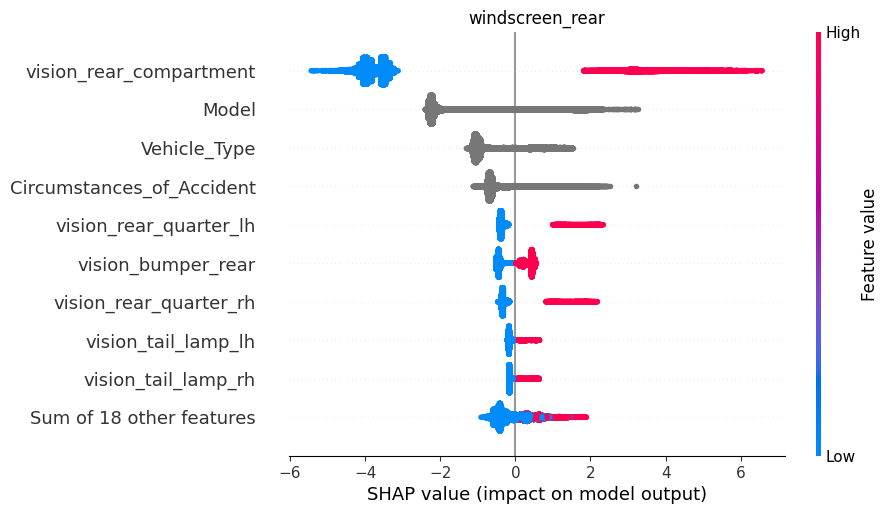

In [33]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test)
plt.title(targetCol[-1])
shap.plots.beeswarm(shap_values)


In [34]:
caseStudyPred = multilabelPred.sample(n=30).head(30)
caseStudyGt = multilabelGt[multilabelGt["CaseID"].isin(caseStudyPred["CaseID"].unique().tolist())]
caseStudyPred.to_csv("case_study_pred.csv")
caseStudyGt.to_csv("case_study_gt.csv")